In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [29]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_TEST'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Benign', 'Malignant']


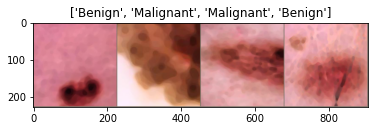

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    epochs = []
    accuracy = []
    loss_list = []
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            epochs.append(epoch)
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                print(epoch_loss)
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                if phase == 'val':
                    loss_list.append(epoch_loss)
                    accuracy.append(epoch_acc)
                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        # Tracer l'exactitude en fonction des époques
        plt.plot(epochs, accuracy)
        plt.xlabel('Époques')
        plt.ylabel('Accuracy')
        plt.title('Exactitude en fonction des époques')
        plt.show()
        # Tracer l'exactitude en fonction des époques
        plt.plot(epochs, loss_list)
        plt.xlabel('Époques')
        plt.ylabel('Loss')
        plt.title('Loss en fonction des époques')
        plt.show()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model


In [31]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [17]:
#method 1 : finetuning the ConvNet (load a pretrained model and reset final fully connected layer)
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
#evaluate the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [32]:
#method 2 : ConvNet as a fixed feature extractor
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/24
----------
0.5903578287973179
train Loss: 0.5904 Acc: 0.7297
0.5369047472017935
val Loss: 0.5369 Acc: 0.7126
Epoch 1/24
----------
0.558605058729805
train Loss: 0.5586 Acc: 0.7507
0.6840419121000959
val Loss: 0.6840 Acc: 0.6437
Epoch 2/24
----------
0.5993625055851899
train Loss: 0.5994 Acc: 0.7349
0.5669225005154637
val Loss: 0.5669 Acc: 0.7299
Epoch 3/24
----------
0.67540042246313
train Loss: 0.6754 Acc: 0.7270
0.6198979279283305
val Loss: 0.6199 Acc: 0.7126
Epoch 4/24
----------
0.5637620004221523
train Loss: 0.5638 Acc: 0.7690
0.6572378163878945
val Loss: 0.6572 Acc: 0.6954
Epoch 5/24
----------
0.5660217637073962
train Loss: 0.5660 Acc: 0.7507
0.5944607336630766
val Loss: 0.5945 Acc: 0.7874
Epoch 6/24
----------
0.6064736610205155
train Loss: 0.6065 Acc: 0.7585
0.6104173351122045
val Loss: 0.6104 Acc: 0.6897
Epoch 7/24
----------
0.43231895112302987
train Loss: 0.4323 Acc: 0.7979
0.5259539416466636
val Loss: 0.5260 Acc: 0.7184
Epoch 8/24
----------
0.43179220493071346


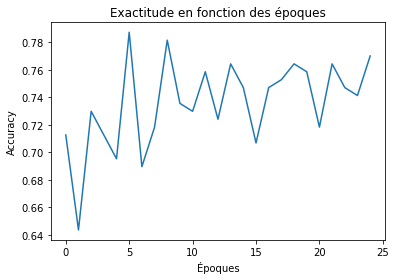

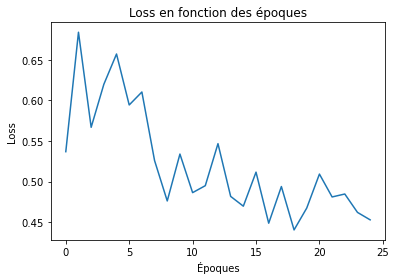

In [33]:
#evaluate the model
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

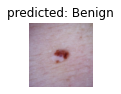

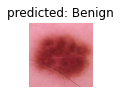

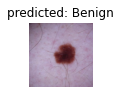

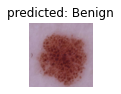

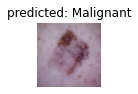

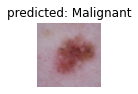

In [20]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [53]:
def visualize_model_predictions(model,img):
    was_training = model.training
    model.eval()

    #img = Image.open(img_path)
    #img = data_transforms['val'](img)
    #img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        
        model.train(mode=was_training)

hey
heybis
heybisbis
C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034321.JPG
heybis
heybisbis
C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034322.JPG
heybis
heybisbis
C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034323.JPG
heybis
heybisbis
C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034324.JPG
heybis
heybisbis
C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034325.JPG
heybis
heybisbis
C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034326.JPG
heybis
heybisbis
C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034328.JPG
heybis
heybisbis
C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034329.JPG
heybis
heybisbis
C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034330.JPG
heybis
heybisbis
C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034331.JPG
heybis
heybisbis
C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\I

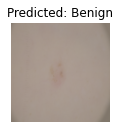

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034322.JPG


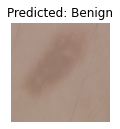

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034323.JPG


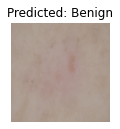

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034324.JPG


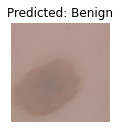

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034325.JPG


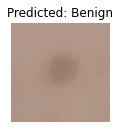

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034326.JPG


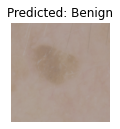

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034328.JPG


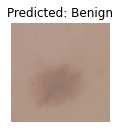

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034329.JPG


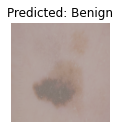

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034330.JPG


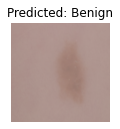

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034331.JPG


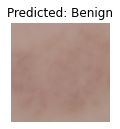

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034332.JPG


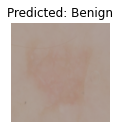

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034333.JPG


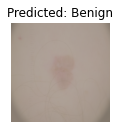

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034334.JPG


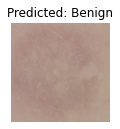

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034335.JPG


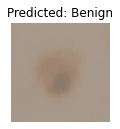

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034336.JPG


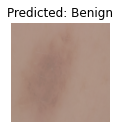

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034337.JPG


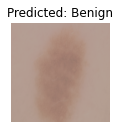

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034338.JPG


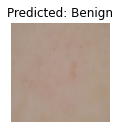

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034339.JPG


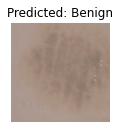

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034340.JPG


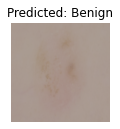

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034341.JPG


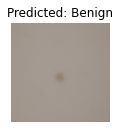

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034342.JPG


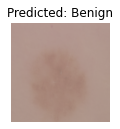

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034343.JPG


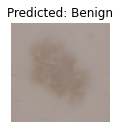

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034344.JPG


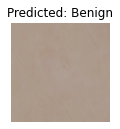

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034345.JPG


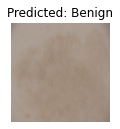

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034346.JPG


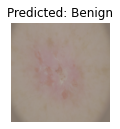

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034347.JPG


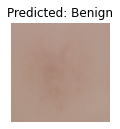

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034348.JPG


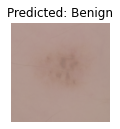

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034349.JPG


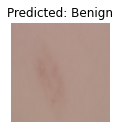

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034350.JPG


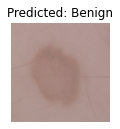

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034351.JPG


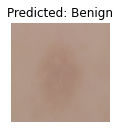

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034352.JPG


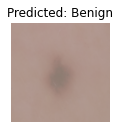

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034354.JPG


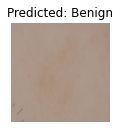

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034355.JPG


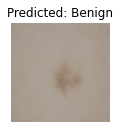

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034356.JPG


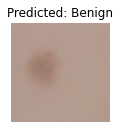

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034357.JPG


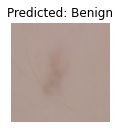

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034359.JPG


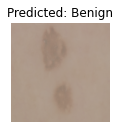

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034360.JPG


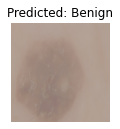

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034361.JPG


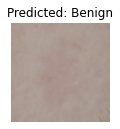

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034362.JPG


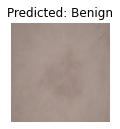

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034363.JPG


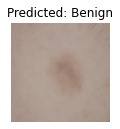

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034364.JPG


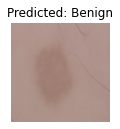

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034365.JPG


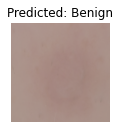

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034366.JPG


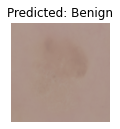

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034367.JPG


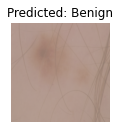

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034368.JPG


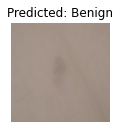

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034369.JPG


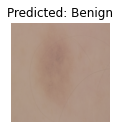

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034370.JPG


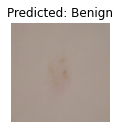

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034371.JPG


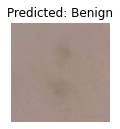

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034372.JPG


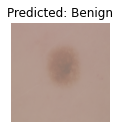

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034374.JPG


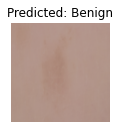

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034375.JPG


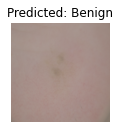

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034376.JPG


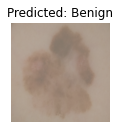

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034377.JPG


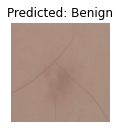

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034378.JPG


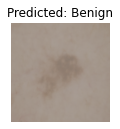

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034379.JPG


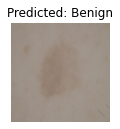

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034380.JPG


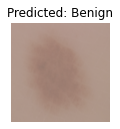

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034381.JPG


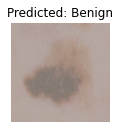

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034382.JPG


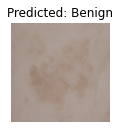

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034383.JPG


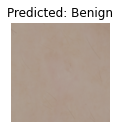

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034385.JPG


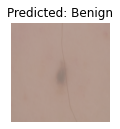

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034386.JPG


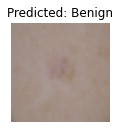

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034387.JPG


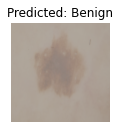

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034389.JPG


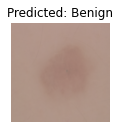

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034390.JPG


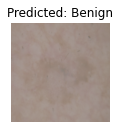

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034391.JPG


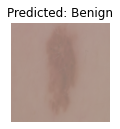

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034392.JPG


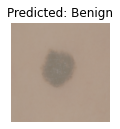

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034393.JPG


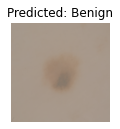

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034394.JPG


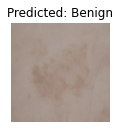

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034395.JPG


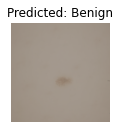

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034396.JPG


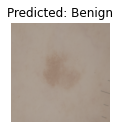

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034397.JPG


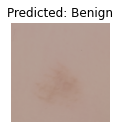

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034398.JPG


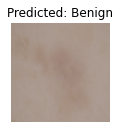

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034399.JPG


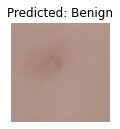

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034400.JPG


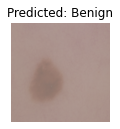

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034401.JPG


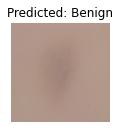

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034402.JPG


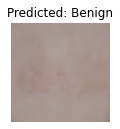

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034403.JPG


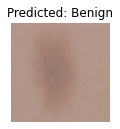

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034404.JPG


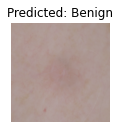

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034405.JPG


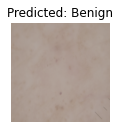

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034406.JPG


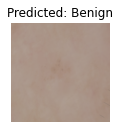

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034407.JPG


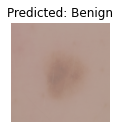

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034408.JPG


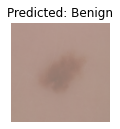

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034409.JPG


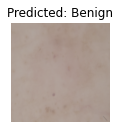

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034410.JPG


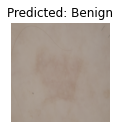

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034411.JPG


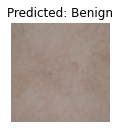

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034412.JPG


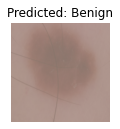

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034413.JPG


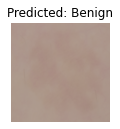

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034414.JPG


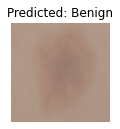

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034415.JPG


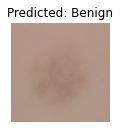

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034416.JPG


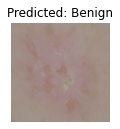

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034417.JPG


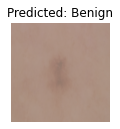

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034418.JPG


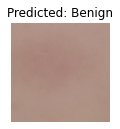

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034419.JPG


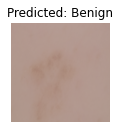

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034420.JPG


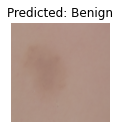

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034421.JPG


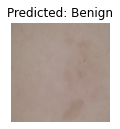

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034422.JPG


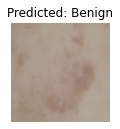

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034423.JPG


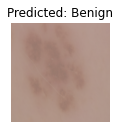

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034424.JPG


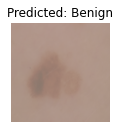

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034425.JPG


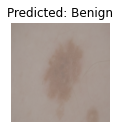

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034426.JPG


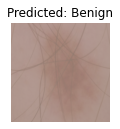

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034427.JPG


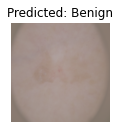

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034428.JPG


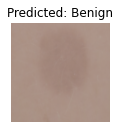

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034429.JPG


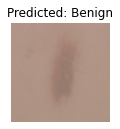

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034430.JPG


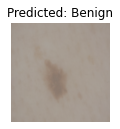

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034431.JPG


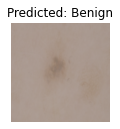

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034433.JPG


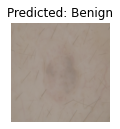

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034434.JPG


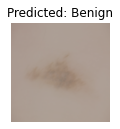

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034435.JPG


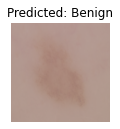

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034436.JPG


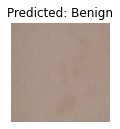

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034437.JPG


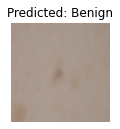

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034438.JPG


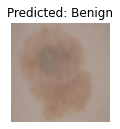

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034439.JPG


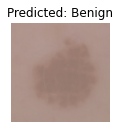

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034440.JPG


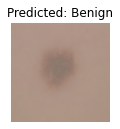

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034441.JPG


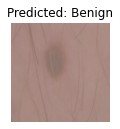

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034442.JPG


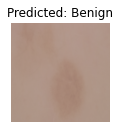

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034443.JPG


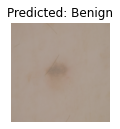

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034444.JPG


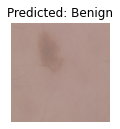

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034445.JPG


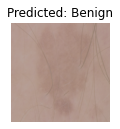

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034446.JPG


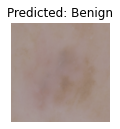

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034447.JPG


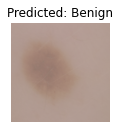

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034448.JPG


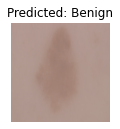

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034449.JPG


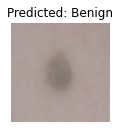

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034450.JPG


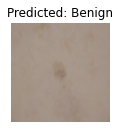

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034451.JPG


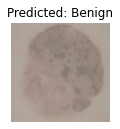

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034452.JPG


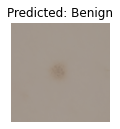

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034453.JPG


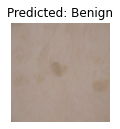

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034454.JPG


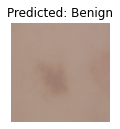

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034455.JPG


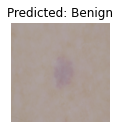

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034456.JPG


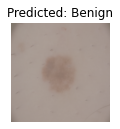

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034457.JPG


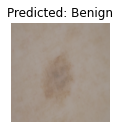

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034458.JPG


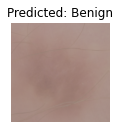

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034459.JPG


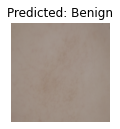

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034460.JPG


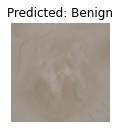

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034461.JPG


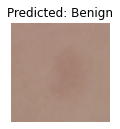

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034463.JPG


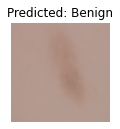

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034464.JPG


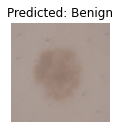

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034465.JPG


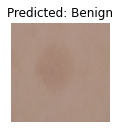

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034466.JPG


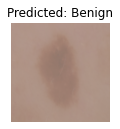

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034467.JPG


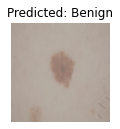

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034468.JPG


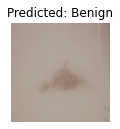

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034469.JPG


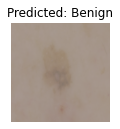

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034470.JPG


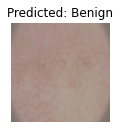

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034471.JPG


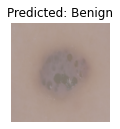

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034472.JPG


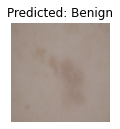

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034474.JPG


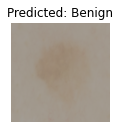

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034475.JPG


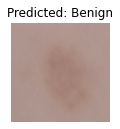

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034476.JPG


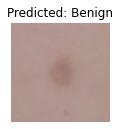

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034477.JPG


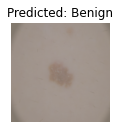

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034478.JPG


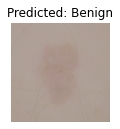

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034480.JPG


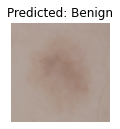

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034481.JPG


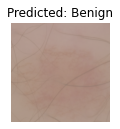

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034482.JPG


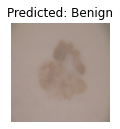

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034483.JPG


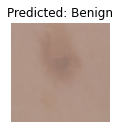

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034484.JPG


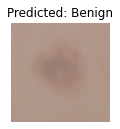

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034485.JPG


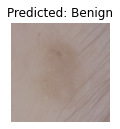

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034486.JPG


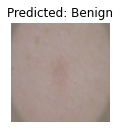

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034487.JPG


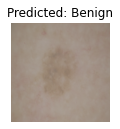

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034488.JPG


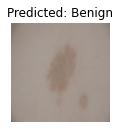

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034489.JPG


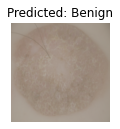

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034490.JPG


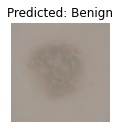

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034491.JPG


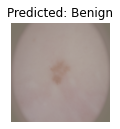

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034492.JPG


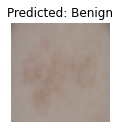

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034493.JPG


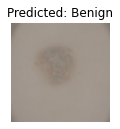

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034494.JPG


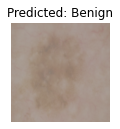

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034495.JPG


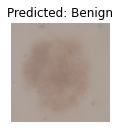

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034496.JPG


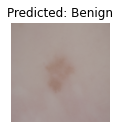

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034497.JPG


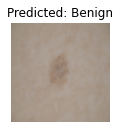

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034498.JPG


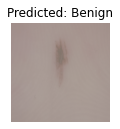

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034499.JPG


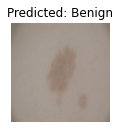

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034500.JPG


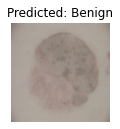

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034501.JPG


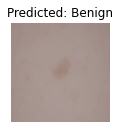

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034502.JPG


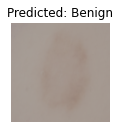

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034503.JPG


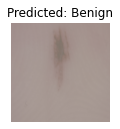

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034504.JPG


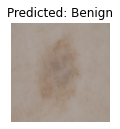

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034505.JPG


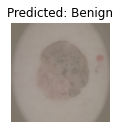

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034506.JPG


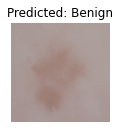

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034507.JPG


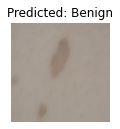

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034508.JPG


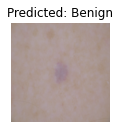

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034509.JPG


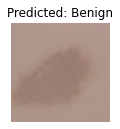

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034510.JPG


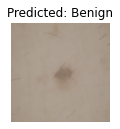

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034511.JPG


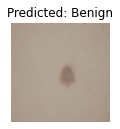

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034512.JPG


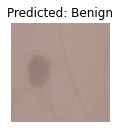

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034513.JPG


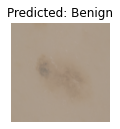

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034514.JPG


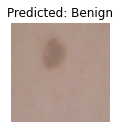

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034515.JPG


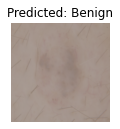

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034516.JPG


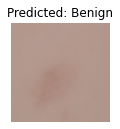

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034517.JPG


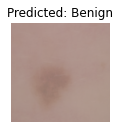

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034518.JPG


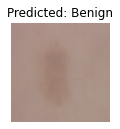

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034519.JPG


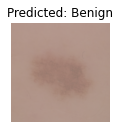

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034520.JPG


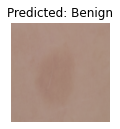

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034521.JPG


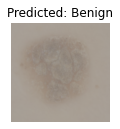

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034522.JPG


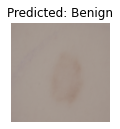

C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation\ISIC_0034523.JPG


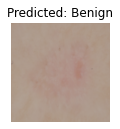

bye


In [69]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Obtenir la liste des chemins d'images
data_dir = 'C:/Users/02bar/Documents/TELECOM/PAF/ISIC_2018_Validation'
image_paths = []

for root, dirs, files in os.walk(data_dir):
    print("hey")
    for file in files:
        print("heybis")
        if file.endswith(('.JPG', '.jpeg', '.png')):
            print("heybisbis")
            image_path = os.path.join(root, file)
            print(image_path)
            image_paths.append(image_path)

# Définir les transformations des données
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
print("hello")
# Appeler visualize_model_predictions pour chaque image
for img_path in image_paths:
    print(img_path)
    img = Image.open(img_path)
    img = data_transforms(img)
    img = img.unsqueeze(0)
    visualize_model_predictions(model_conv, img)
    plt.ioff()
    plt.show()
print("bye")

## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).



